<a href="https://colab.research.google.com/github/Gaoshan-Pan/Final_work/blob/main/v2_Sales_foreasting_for_superstore_retail_Part3(Comparison).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time-Series Forecasting of Sales in the Retail Domain



In [2]:
# Install a binary compatible package with pmdarima
!pip install "numpy<2.0" "pmdarima==2.0.3"  # 2.0.3 is the current stable and compiled version on PyPI

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 73.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


# Restart the kernel and then run import

In [1]:
# All imports
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import root_mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

## Load dataset <a name="data_understanding__load_dataset" id="data_understanding__load_dataset"></a>

In [2]:
# import kagglehub
# rohitsahoo_sales_forecasting_path = kagglehub.dataset_download('rohitsahoo/sales-forecasting')

# print('Import is completed.')


In [4]:
# # Load the dataset
# df=pd.read_csv('/kaggle/input/sales-forecasting/train.csv')
# # Link to Dataset on Kaggle: Superstore Sales Dataset: https://www.kaggle.com/datasets/rohitsahoo/sales-forecasting/
df=pd.read_csv('/content/train_cleaned_after_deleting_lost_customers.csv')

In [5]:
# ── Missing-value summary ────────────────────────────────────────────────
total_na   = df.isna().sum().sum()
by_column  = df.isna().sum().sort_values(ascending=False)

print(f"Total missing values in entire DataFrame: {total_na}\n")
print("Missing values by column:")
display(by_column)          # In a notebook, displays a neat Series table


Total missing values in entire DataFrame: 0

Missing values by column:


,0
Order ID,0
Order Date,0
Ship Mode,0
Customer ID,0
Customer Name,0
Segment,0
Country,0
Product ID,0
Category,0
Sub-Category,0


## Handle with missing/null values and non-meaningful data


In [6]:
# # ── Handle missing / null values ─────────────────────────────────────────────
# # Only a tiny share of the dataset, we can safely remove those rows instead of imputing them.
# df = df.dropna(subset=["Postal Code"])
# df.shape
# # ── Remove features that add no value or raise privacy concerns ──────────────
# # 1. 'Row ID' is simply a unique identifier, so it does not contribute
# #    useful information for analysis or modelling.
# df.drop("Row ID", axis="columns", inplace=True)

# # 2. 'Customer Name' is omitted to minimise the risk of exposing
# #    personally identifiable information during processing.
# df.drop("Customer Name", axis="columns", inplace=True)

## Data conversion-Convert column data types


In [7]:
# # 1. Parse the order date strings into true datetime objects.
# df["Order Date"] = pd.to_datetime(df["Order Date"],
#                                   format="%d/%m/%Y",   # adjust if needed
#                                   errors="raise")       # stop if a value is malformed

# # 2. Convert the shipping dates; treat any impossible values as missing.
# df["Ship Date"] = pd.to_datetime(df["Ship Date"], errors="coerce")

# # 3. Cast to a nullable integer so NAs are still allowed.
# df["Postal Code"] = df["Postal Code"].astype("Int64")

# # 4. Change string-like columns with a limited set of distinct values
# #    to the 'category' dtype to save memory and speed up grouping.
# cat_cols = [
#     "Ship Mode", "Segment", "Country", "City",
#     "State", "Region", "Category", "Sub-Category"
# ]

# df[cat_cols] = df[cat_cols].astype("category")
# 1. Parse the order date strings into true datetime objects.
df["Order Date"] = pd.to_datetime(df["Order Date"],
                                  format="%Y-%m-%d",   # Adjusted format to match "YYYY-MM-DD"
                                  errors="raise")       # stop if a value is malformed


In [8]:
# Convert all categorical features from object type to category type
df['Ship Mode'] = df['Ship Mode'].astype('category')
df['Segment'] = df['Segment'].astype('category')
df['Country'] = df['Country'].astype('category')

df['Category'] = df['Category'].astype('category')
df['Sub-Category'] = df['Sub-Category'].astype('category')

## Sort by Order Date in order to do sales forecasting


In [9]:
# Sort by Order Date
df.sort_values(by=['Order Date'], inplace=True)
df.head()

,Order ID,Order Date,Ship Mode,Customer ID,Customer Name,Segment,Country,Product ID,Category,Sub-Category,Product Name,Sales
0,CA-2015-103800,2015-01-03,Standard Class,DP-13000,Darren Powers,Consumer,United States,OFF-PA-10000174,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.448
1,CA-2015-112326,2015-01-04,Standard Class,PO-19195,Phillina Ober,Home Office,United States,OFF-BI-10004094,Office Supplies,Binders,GBC Standard Plastic Binding Systems Combs,3.540
2,CA-2015-112326,2015-01-04,Standard Class,PO-19195,Phillina Ober,Home Office,United States,OFF-ST-10002743,Office Supplies,Storage,SAFCO Boltless Steel Shelving,272.736
3,CA-2015-112326,2015-01-04,Standard Class,PO-19195,Phillina Ober,Home Office,United States,OFF-LA-10003223,Office Supplies,Labels,Avery 508,11.784
4,CA-2015-141817,2015-01-05,Standard Class,MB-18085,Mick Brown,Consumer,United States,OFF-AR-10003478,Office Supplies,Art,Avery Hi-Liter EverBold Pen Style Fluorescent ...,19.536


From data decription before, we know this time line is from 2015-01-03 to 2018-12-30

# Part 3-Model comparison


In [10]:
# Since this is a time-series forecasting problem, the data should be split by past dates to train on, and future dates to predict. So I will use data from the years 2015 to 2017 for training, and use the data of the year 2018 for validation and testing (6 months for each)
train_start = pd.to_datetime('2015-01-31')  #using the last date of the month, since the grouping will be done by month
train_end = pd.to_datetime('2017-6-30')
validate_start = pd.to_datetime('2017-07-31')
validate_end = pd.to_datetime('2018-06-30')
test_start = pd.to_datetime('2018-07-31')
test_end = pd.to_datetime('2018-12-31')

In [11]:
#

def create_sequences_for_lstm(data, window_size):
    training_seq_series = []
    training_label_series = []
    for i in range(len(data) - window_size - 1):
        training_seq = data[i:(i + window_size)]
        training_label = data[i + window_size]
        training_seq_series.append(training_seq)
        training_label_series.append(training_label)
    return np.array(training_seq_series), np.array(training_label_series)

# This function splits the time series data into training, validation, and testing sets based on specified date ranges.
# It uses the sequenced inputs/labels and the original date column to calculate index-based slicing.

def split(date_column,
          sequencedX, sequencedY,
          train_start_date, train_end_date,
          validate_start_date, validate_end_date,
          test_start_date, test_end_date,
          window_size):

    training_size = int(np.sum((date_column >= train_start_date) & (date_column <= train_end_date)) - window_size - 1)
    validation_size = int(np.sum((date_column >= validate_start_date) & (date_column <= validate_end_date)))

    X_training = sequencedX[:training_size]
    y_training = sequencedY[:training_size]
    X_validation = sequencedX[training_size:training_size+validation_size]
    y_validation = sequencedY[training_size:training_size+validation_size]
    X_testing = sequencedX[training_size+validation_size:]
    y_testing = sequencedY[training_size+validation_size:]

    return X_training, y_training, X_validation, y_validation, X_testing, y_testing

# LSTM input format must be 3D: [samples, time steps, features]. This reshapes the data accordingly.
def reshape(X_training, X_validation, X_testing):
    X_training = np.reshape(X_training, (X_training.shape[0], X_training.shape[1], 1))
    X_validation = np.reshape(X_validation, (X_validation.shape[0], X_validation.shape[1], 1))
    X_testing = np.reshape(X_testing, (X_testing.shape[0], X_testing.shape[1], 1))

    return X_training, X_validation, X_testing

# Visualizes the training and validation loss across epochs for model performance monitoring.
def plot_training_validation_loss(model_history, round_number, title_override=None):
    plt.figure(figsize=(8, 5))
    plt.plot(model_history.history['loss'], label='Training Loss')
    plt.plot(model_history.history['val_loss'], label='Validation Loss')
    if title_override is not None:
        plt.title(title_override)
    else:
        plt.title('Round' + round_number + ': Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Generates sales predictions on a given dataset, reverses the scaling to restore original values, and calculates RMSE.
def predict_sales(model, X_data, y_labels, scaler):
    predicted_sales = model.predict(X_data)
    unscaled_predictions = scaler.inverse_transform(predicted_sales)
    unscaled_labels = scaler.inverse_transform(y_labels.reshape(-1, 1))
    rmse = sqrt(root_mean_squared_error(unscaled_labels, unscaled_predictions))
    return unscaled_predictions, unscaled_labels, rmse

def plot_training_and_validation_time_series_lstm(dataframe, date_column_name, sales_column_name,
                                                predicted_sales_on_training, predicted_sales_on_validation,
                                                scaler, title):
    # Set custom style
    plt.style.use('ggplot')

    plt.figure(figsize=(15, 5), facecolor='#f5f5f5')

    # Create empty arrays for plotting
    training_plot_array = np.empty_like(dataframe[sales_column_name])
    training_plot_array[:] = np.nan
    training_plot_array[window:len(predicted_sales_on_training)+window] = predicted_sales_on_training.flatten()

    starting_index = len(predicted_sales_on_training) + window
    ending_index = starting_index + len(predicted_sales_on_validation)

    validation_plot_array = np.empty_like(dataframe[sales_column_name])
    validation_plot_array[:] = np.nan
    validation_plot_array[starting_index:ending_index] = predicted_sales_on_validation.flatten()

    # Plot with custom styling
    plt.plot(dataframe[date_column_name],
             scaler.inverse_transform(dataframe[[sales_column_name]]),
             color='#2c3e50',
             linewidth=2.5,
             linestyle='-',
             alpha=0.9,
             label="Original Data")

    plt.plot(dataframe[date_column_name],
             training_plot_array,
             color='#e74c3c',
             linewidth=2,
             linestyle='--',
             alpha=0.8,
             label="Training Predictions")

    plt.plot(dataframe[date_column_name],
             validation_plot_array,
             color='#27ae60',
             linewidth=2,
             linestyle='-.',
             alpha=0.8,
             label="Validation Predictions")

    # Customize plot appearance
    plt.title(title, pad=20, fontsize=14, fontweight='bold')
    plt.legend(framealpha=0.9, facecolor='white', edgecolor='#333333')
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.gca().set_facecolor('#f9f9f9')

    plt.tight_layout()
    plt.show()

def plot_testing_time_series_lstm(dataframe, date_column_name,
                                predicted_sales_on_testing,
                                y_labels_on_testing,
                                testing_start_date,
                                title,
                                x_axis_ticks_obj,
                                x_axis_ticks_formatter,
                                x_axis_ticks_rotation_angle):

    plt.figure(figsize=(12, 6), facecolor='#f8f9fa')

    test_data = dataframe[dataframe[date_column_name] >= testing_start_date]

    plt.plot(test_data[date_column_name], y_labels_on_testing,
            color='#3498db', linewidth=2.5, alpha=0.9,
            label='Actual Sales', marker='o', markersize=4)

    plt.plot(test_data[date_column_name], predicted_sales_on_testing,
            color='#e74c3c', linewidth=2, linestyle='--',
            alpha=0.8, label='Predicted Sales', marker='^', markersize=5)

    plt.xlabel('Date', fontsize=12, labelpad=10)
    plt.ylabel('Sales', fontsize=12, labelpad=10)
    plt.gca().xaxis.set_major_locator(x_axis_ticks_obj)

    if x_axis_ticks_formatter is not None:
        plt.gca().xaxis.set_major_formatter(x_axis_ticks_formatter)

    plt.xticks(rotation=x_axis_ticks_rotation_angle, ha='right', fontsize=10)
    plt.yticks(fontsize=10)

    plt.title(title, pad=20, fontsize=14, fontweight='bold')
    plt.legend(framealpha=1, facecolor='white', edgecolor='#95a5a6',
              fontsize=10, frameon=True)

    plt.grid(True, linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.show()


def plot_testing_time_series_arima_and_sarima(test_data, predictions, title):
    plt.figure(figsize=(12, 6), facecolor='#f8f9fa')

    plt.plot(test_data, color='#2ecc71', linewidth=2.5,
            alpha=0.9, label='Actual Sales', marker='o', markersize=4)

    plt.plot(predictions, color='#9b59b6', linewidth=2, linestyle='--',
            alpha=0.8, label='Predicted Sales', marker='s', markersize=5)

    plt.xlabel('Date', fontsize=12, labelpad=10)
    plt.ylabel('Sales', fontsize=12, labelpad=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.title(title, pad=20, fontsize=14, fontweight='bold')
    plt.legend(framealpha=1, facecolor='white', edgecolor='#95a5a6',
              fontsize=10, frameon=True)

    plt.grid(True, linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.show()

##ARIMA

In [12]:
#For detailed explanation of the steps, see detailed comments on code cells in Round 1
df_arima = df[['Order Date', 'Sales']]
df_arima = df_arima.rename(columns={'Order Date': 'date', 'Sales': 'sales'})
df_arima.set_index('date', inplace = True)
df_arima = df_arima.sort_index()
df_arima.head()

,sales
date,
2015-01-03,16.448
2015-01-04,3.540
2015-01-04,272.736
2015-01-04,11.784
2015-01-05,19.536


In [13]:
df_arima = df_arima.resample('ME')['sales'].sum()

train_data_arima = df_arima.loc[:train_end]
test_data_arima = df_arima.loc[test_start:test_end]

In [14]:
p, d, q = 5, 1, 1
# Create the ARIMA model
model_arima = ARIMA(train_data_arima, order=(p, d, q))
model_fit_arima = model_arima.fit()

Evaluation：


In [15]:
predictions_arima = model_fit_arima.predict(start=test_start, end=test_end)

In [16]:
rmse_test7 = sqrt(root_mean_squared_error(test_data_arima, predictions_arima))
print(f'ARIMA RMSE on TEST Data: {rmse_test7}')

ARIMA RMSE on TEST Data: 221.76160791163514


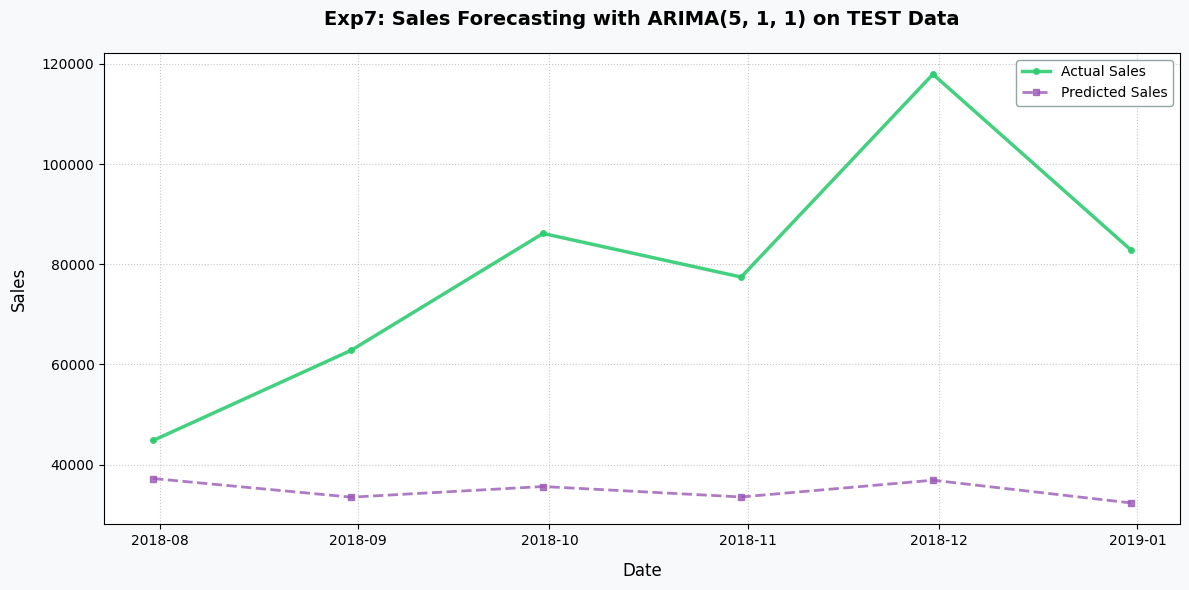

In [17]:
title = f'Exp7: Sales Forecasting with ARIMA({p}, {d}, {q}) on TEST Data'
plot_testing_time_series_arima_and_sarima(test_data_arima, predictions_arima, title)

Iteration：

In [18]:
#For detailed explanation of the steps, see detailed comments on code cells in Round 1
df_sarima = df[['Order Date', 'Sales']]
df_sarima = df_sarima.rename(columns={'Order Date': 'date', 'Sales': 'sales'})
df_sarima.set_index('date', inplace = True)
df_sarima = df_sarima.sort_index()

In [19]:
# Group by monthly sales, and aggregate by SUM
df_sarima = df_sarima.resample('ME')['sales'].sum()
df_sarima.head()

,sales
date,
2015-01-31,13529.023
2015-02-28,4477.670
2015-03-31,52458.852
2015-04-30,25395.985
2015-05-31,22191.406


In [20]:
# Split data into training, and testing by the dates specified earlier.
train_data_sarima = df_sarima.loc[:train_end]
test_data_sarima = df_sarima.loc[test_start:test_end]
train_data_sarima.head()

,sales
date,
2015-01-31,13529.023
2015-02-28,4477.670
2015-03-31,52458.852
2015-04-30,25395.985
2015-05-31,22191.406


SARIMA：

In [21]:
# Decide on the SARIMA parameters: p, d, q, P, D, Q, s. Temporarily set to arbitrary values, I will auto-detect these in the next round
p, d, q = 5, 1, 1
P, D, Q, s = 1, 1, 1, 12  # Seasonal period (s) is 12 for monthly data

In [22]:
# Create the SARIMA model
model_sarima = SARIMAX(train_data_sarima, order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit_sarima = model_sarima.fit(disp=False)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluation：

In [23]:
# Do the time-series prediction
predictions_sarima = model_fit_sarima.predict(start=test_start, end=test_end)

In [24]:
# Evaluate using RMSE
rmse_test8 = sqrt(root_mean_squared_error(test_data_sarima, predictions_sarima))
print(f'Exp8 (SARIMA): RMSE on TEST Data: {rmse_test8}')

Exp8 (SARIMA): RMSE on TEST Data: 134.95380321483339


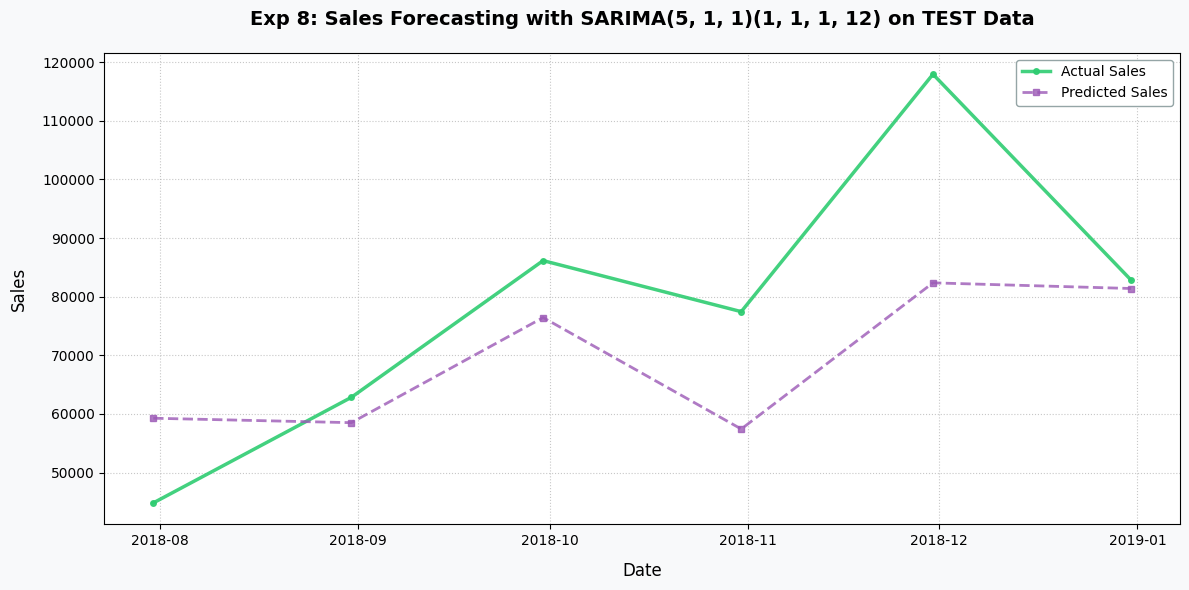

In [25]:
# Plot the results of prediction on TEST data
title = f'Exp 8: Sales Forecasting with SARIMA({p}, {d}, {q})({P}, {D}, {Q}, {s}) on TEST Data'
plot_testing_time_series_arima_and_sarima(test_data_sarima, predictions_sarima, title)

## SARIMA with Auto Fine-tuning ：


This round introduces ​​SARIMA (Seasonal ARIMA)​​ with ​​automated hyperparameter tuning​​ to determine if classical time-series methods can outperform our previous LSTM results

In [26]:
#For detailed explanation of the steps, see detailed comments on code cells in Round 1
df_sarima_tuned = df[['Order Date', 'Sales']]
df_sarima_tuned = df_sarima_tuned.rename(columns={'Order Date': 'date', 'Sales': 'sales'})
df_sarima_tuned.set_index('date', inplace = True)
df_sarima_tuned = df_sarima_tuned.sort_index()

In [27]:
# Group by monthly sales, and aggregate by SUM
df_sarima_tuned = df_sarima_tuned.resample('ME')['sales'].sum()

In [28]:
# Split data into training, and testing by the dates specified earlier.
train_data_sarima_tuned = df_sarima_tuned.loc[train_start:train_end]
test_data_sarima_tuned = df_sarima_tuned.loc[test_start:test_end]

In [29]:
# Use AutoARIMA to pick the best values for parameters: p, d, q, P, D, Q.
params = auto_arima(train_data_sarima_tuned, seasonal=True, m=12, trace=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=679.386, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=677.586, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=677.598, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=674.337, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=720.462, Time=0.02 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=679.548, Time=0.05 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=676.233, Time=0.10 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=674.859, Time=0.14 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=680.524, Time=0.13 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=676.823, Time=0.19 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=672.942, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=674.682, Time=0.07 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=673.607, Time=0.13 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=678.194, Time=0.05 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=675.473, Time=0.18 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=674.788, Time=0.07 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=676.333, Time=0.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,1)[12]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,1)[12] intercept
Total fit time: 2.205 seconds


In [30]:
print(params)
print(params.order)
print(params.seasonal_order)

 ARIMA(0,0,0)(0,0,1)[12] intercept
(0, 0, 0)
(0, 0, 1, 12)


In [31]:
# Create the SARIMA fine-tuned model
model_sarima_tuned = SARIMAX(train_data_sarima_tuned, order=params.order, seasonal_order=params.seasonal_order, trend = 'c')   #trend=c corresponds to including the intercept flag
model_fit_sarima_tuned = model_sarima_tuned.fit(disp=False)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Evaluation

In [32]:
# Do the time-series prediction
predictions_sarima_tuned = model_fit_sarima_tuned.predict(start=test_start, end=test_end)

rmse_test9 = sqrt(root_mean_squared_error(test_data_sarima_tuned, predictions_sarima_tuned))
print(f'Auto tuned SARIMA RMSE on TEST Data: {rmse_test9}')

Auto tuned SARIMA RMSE on TEST Data: 223.92962871584814
